In [83]:
# load packages
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import os
from datetime import datetime
from sklearn.datasets import make_spd_matrix
from torch.utils.data import random_split, DataLoader
from scipy.stats import qmc
import time

In [84]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

In [85]:
def integration_points(n_int):
    points = torch.linspace(0, 4, n_int+1)[:-1]
    points += torch.rand(points.shape) * (1 / n_int) + np.random.rand() * 0.05 # random shift

    # points on square
    epsilon =  0.1 # changeable: set the boundary an espilon away from the Omega boundary
    side = 2 + 2*epsilon
    middle = torch.tensor((0,0)).view(1,2)
    points = torch.remainder(points, 4) # transform points to [0,4]
    v1 = torch.tensor((0, side))[None,]
    v2 = torch.tensor((side, 0))[None,]
    v3 = torch.tensor((0, -side))[None,]
    v4 = torch.tensor((-side, 0))[None,]
    points = points.view(-1,1)
    x_int = (middle - 0.5 * (v1 + v2) + torch.clamp(points,0,1) * v1 + torch.clamp(points-1,0,1) * v2 + torch.clamp(points-2,0,1) * v3 + torch.clamp(points-3,0,1) * v4).requires_grad_(True)

    return x_int

In [86]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x):

    middle = torch.tensor((0,0)).view(1,2)
    max_indices = torch.argmax(torch.abs(x - middle), dim=-1, keepdim=False)
    normals = torch.zeros_like(x)
    sign = torch.sign(x)
    temp_range = torch.arange(x.size(0))
    normals[temp_range, max_indices] = sign[temp_range, max_indices]

    return normals


In [87]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y, L=None):
    diff = x - y
    if L is None:
        L = torch.tensor(4 * 2 / y.shape[0], dtype=x.dtype, device=x.device)

    Phi_analytic = -L / (2 * torch.pi) * (torch.log(L / 2) - 1)    
    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)

    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):
    diff = x - y
    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    grad_analytic = torch.full_like(diff, -0.5)
    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

In [88]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers, n_int):

        super().__init__()
        activation = nn.Tanh
        self.n_int = n_int

        # input / start layer
        self.fc_start = nn.Sequential(*[
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ])
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)

    #------------------------------
    # forward pass through network
    def forward(self, x):
        # map x to [-1,1]
        epsilon =  0.1
        x_scaled = 2*(x - torch.tensor([-1-epsilon, -1-epsilon]))/(torch.tensor([1+epsilon, 1+epsilon]) - torch.tensor([-1-epsilon, -1-epsilon])) - 1
        #x_scaled = 2*(x - torch.tensor([x_min, y_min]))/(torch.tensor([x_max, y_max]) - torch.tensor([x_min, y_min])) - 1
        # forward pass
        x_scaled = self.fc_start(x_scaled)  # input layer
        x_scaled = self.fc_hidden(x_scaled) # hidden layer(s)
        u = self.fc_end(x_scaled)    # output layer
        return u

    #------------------------------
    # calculating the potential integrals
    def resample(self):
        # sampling new collocation and integration points
        self.x_int = integration_points(self.n_int)
        # calculating the potential
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')

    #------------------------------
    # calculating the single and double layer potentials for x being an inside Omega point
    def calc_potentials_inside(self, x):

        epsilon =  0.1
        side = 2 + 2*epsilon

        y = self.x_int
        normal_y = outer_normal(y)
        h_y = self(y) # boundary density, performs forward pass through  neural network with the input y

        # single_layer
        #L = torch.tensor(4 * 2 / self.n_int, dtype=torch.float32, device=y.device)
        #G = - L / (2 * torch.pi) * (torch.log(L / 2) - 1)        
        #L = torch.tensor(4 * 2 / self.n_int)


        G =  fundamental_solution(x, y)
         
        grad_ones = torch.ones_like(h_y)
        dh_dy = torch.autograd.grad(h_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dh_dn = torch.sum(dh_dy * normal_y, dim=1).view(-1, 1)
        single_layer = 4*side*torch.mean(G * dh_dn)
        ################
        # double_layer
        dG_dy =  gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        h_y_exact = u_analytic(y[:,0], y[:,1])
        double_layer = 4*side*torch.mean(dG_dn * h_y_exact)
        ################
        # boudary case

        f= 32*((1 - y[:,1])*y[:,1] + (1 - y[:,0])*y[:,0]) 
        boundary_case = 4*side*torch.mean(0.5 * h_y)

        return single_layer.squeeze(), double_layer.squeeze(), boundary_case.squeeze()

    #------------------------------
    def predict_u_inside(self, x):
        y = self.x_int
        single_layer, double_layer, boundary_case = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)

        return u_int_data

In [89]:
def initialise_pibi(lr, n_int):

    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 50 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers, n_int)
    
    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error
    
    return pibi, optimiser, mse_loss

In [90]:
# Número de muestras a generar (para malla regular y para LHS)
n_samples = 200 # number of samples
n_int = 500 # number of integration points

# Crear malla regular en el dominio [0,1]x[0,1]
x = np.linspace(-1, 1, n_samples)
y = np.linspace(-1, 1, n_samples)
X_grid, Y_grid = np.meshgrid(x, y)

# Evaluar solución analítica sobre la malla regular
U_grid = u_analytic(X_grid, Y_grid)

# Aplanar y combinar en una matriz (x, y, u) para la malla regular
num_points = n_samples ** 2
XU_grid = np.column_stack((
    X_grid.reshape(num_points),
    Y_grid.reshape(num_points),
    U_grid.reshape(num_points)
))

# Generar muestras usando Latin Hypercube Sampling (LHS)
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_samples = lhs_sampler.random(n=n_samples)

# Escalar las muestras al dominio [0,1]x[0,1]
domain_bounds_lower = [-1, -1]
domain_bounds_upper = [1, 1]
lhs_scaled = qmc.scale(lhs_samples, domain_bounds_lower, domain_bounds_upper)

# Evaluar solución analítica en las muestras LHS
X_lhs, Y_lhs = lhs_scaled[:, 0], lhs_scaled[:, 1]
U_lhs = u_analytic(X_lhs, Y_lhs)

# Combinar en una matriz (x, y, u) para las muestras LHS
XU_lhs = np.column_stack((X_lhs, Y_lhs, U_lhs))

# generar puntos de integración
x_int = integration_points(n_int)


In [ ]:
# Número total de muestras en la frontera
n_samples = 200  # debe ser divisible por 4 preferentemente

# LHS en 1D para cada lado
n_side = n_samples // 4
lhs_1d = qmc.LatinHypercube(d=1).random(n=n_side)
lhs_1d = 2 * lhs_1d - 1  # escalar a [-1, 1]

# Lados del cuadrado: abajo, arriba, izquierda, derecha
bottom = np.column_stack((lhs_1d[:, 0], -np.ones(n_side)))
top = np.column_stack((lhs_1d[:, 0], np.ones(n_side)))
left = np.column_stack((-np.ones(n_side), lhs_1d[:, 0]))
right = np.column_stack((np.ones(n_side), lhs_1d[:, 0]))

# Unir todos los puntos de frontera
boundary_points = np.vstack((bottom, top, left, right))

# Evaluar la solución analítica en la frontera
X_lhs, Y_lhs = boundary_points[:, 0], boundary_points[:, 1]
U_lhs = u_analytic(X_lhs, Y_lhs)

# Matriz (x, y, u)
XU_lhs_boundary = np.column_stack((X_lhs, Y_lhs, U_lhs))


In [92]:
#XU_lhs = np.vstack((XU_lhs_interior, XU_lhs_boundary))

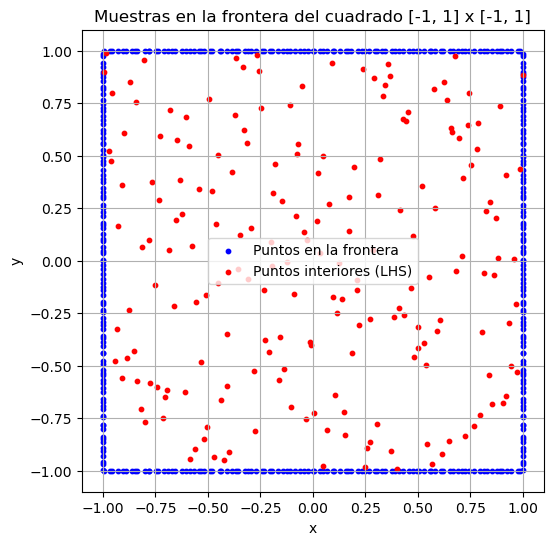

In [93]:
# Graficar los puntos de la frontera
plt.figure(figsize=(6, 6))
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='blue', s=10, label='Puntos en la frontera')
plt.scatter(XU_lhs_interior[:, 0], XU_lhs_interior[:, 1], color='red', s=10, label='Puntos interiores (LHS)')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Muestras en la frontera del cuadrado [-1, 1] x [-1, 1]')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

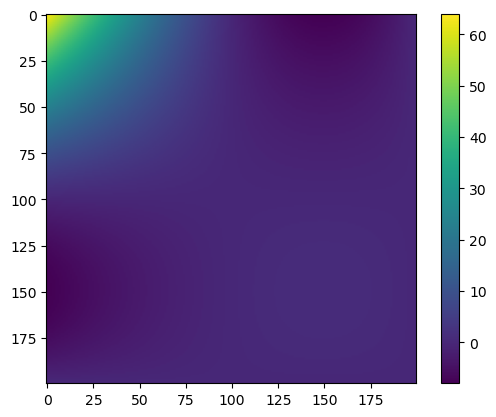

In [94]:
plt.imshow(U_grid)
plt.colorbar()
plt.show()

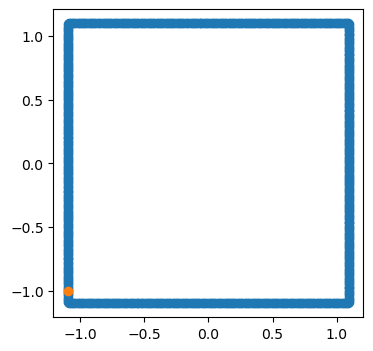

In [95]:
# plot outer normal and x_int
figure, ax = plt.subplots(figsize=(4, 4))
plt.scatter(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy())
plt.scatter(x_int[5, 0].detach().numpy(), x_int[5, 1].detach().numpy())
plt.show()
#plt.quiver(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy(), outer_normal(x_int)[:, 0].detach().numpy(), outer_normal(x_int)[:, 1].detach().numpy())

In [96]:
def train_pibi(iterations, pibi, optimiser, mse_loss, data, data_n, n_samples, n_int, time_now, show_plots):

    # store loss values
    loss_values = []
 
    for epoch in range(iterations):

        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()

        # compute data loss
        pibi.resample()
        u_int_data = pibi.predict_u_inside(data[:,0:2])
        #source_data = torch.zeros_like(u_int_data)
        source_data = (32*((1 - data[:,1])*data[:,1] + (1 - data[:,0])*data[:,0]))* fundamental_solution(data[:,0:2], torch.ones_like(data[:,0:2])).view(-1,1)
        u_int_data = u_int_data +  source_data
        loss = mse_loss(u_int_data, data[:,-1].view(-1,1))
        loss_values.append(loss.item())

        # backpropagate loss, take optimiser step
        loss.backward()
        optimiser.step()
        print('Epoch:', epoch, 'Loss:', loss.item())

    return pibi, loss_values

In [97]:
show_plots = True

# take samples
time_now = datetime.now().strftime("%Y%m%d_%H%M")
data = torch.tensor(XU_lhs, dtype=torch.float64)
data_ = torch.tensor(XU_grid, dtype=torch.float64)

# pibi initialisation
lr = 0.001 # learning rate
pibi, optimiser, mse_loss = initialise_pibi(lr, n_int)
    
# train pibi-net
iterations = 1_001
pibi, loss_values = train_pibi(iterations, pibi, optimiser, mse_loss, data, 00, n_samples, n_int, time_now, show_plots)

/home/orincon/miniconda3/envs/bem/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 117.29852062453469
Epoch: 1 Loss: 117.29135840011917
Epoch: 2 Loss: 117.11142635289251
Epoch: 3 Loss: 117.07799982575332
Epoch: 4 Loss: 116.94451772001241
Epoch: 5 Loss: 116.93545817136639
Epoch: 6 Loss: 116.7725721896241
Epoch: 7 Loss: 116.70488981504518
Epoch: 8 Loss: 116.66490687539066
Epoch: 9 Loss: 116.45353938205265
Epoch: 10 Loss: 116.41309717167688
Epoch: 11 Loss: 116.32454418800785
Epoch: 12 Loss: 116.25548681925319
Epoch: 13 Loss: 116.07175970196333
Epoch: 14 Loss: 115.94753922039257
Epoch: 15 Loss: 115.75723255166858
Epoch: 16 Loss: 115.63970697121759
Epoch: 17 Loss: 115.46830385568734
Epoch: 18 Loss: 115.2596801451874
Epoch: 19 Loss: 115.07617282822542
Epoch: 20 Loss: 114.80792154293074
Epoch: 21 Loss: 114.62520746746506
Epoch: 22 Loss: 114.33742429451691
Epoch: 23 Loss: 114.07759077378805
Epoch: 24 Loss: 113.83846016955222
Epoch: 25 Loss: 113.55370511568105
Epoch: 26 Loss: 113.22187404895597
Epoch: 27 Loss: 112.88092388135964
Epoch: 28 Loss: 112.511652009366

In [98]:
data_ = torch.tensor(XU_grid, dtype=torch.float64)

u_pred = pibi.predict_u_inside(data_[:,0:2])
u_pibi = u_pred.reshape(X_grid.shape)

plt.figure(figsize=(5, 5))
plt.imshow(u_pibi.detach())
plt.colorbar()
plt.show()

RuntimeError: [enforce fail at alloc_cpu.cpp:118] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 80000000000 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
def train_pibi_lbfgs(pibi, mse_loss, data, max_iter=100):
    print("\nStarting L-BFGS refinement...")

    def closure():
        optimizer_lbfgs.zero_grad()
        pibi.resample()  # en caso de que resamplee los puntos en cada forward
        u_int_data = pibi.predict_u_inside(data[:, :2])
        loss = mse_loss(u_int_data, data[:, -1].view(-1, 1))
        loss.backward()
        return loss

    optimizer_lbfgs = torch.optim.LBFGS(
        pibi.parameters(),
        lr=1,
        max_iter=max_iter,
        history_size=100,
        line_search_fn="strong_wolfe",
        tolerance_grad=1e-7,
        tolerance_change=1.0 * np.finfo(float).eps
    )

    loss_values_lbfgs = []

    for i in range(max_iter):
        loss = optimizer_lbfgs.step(closure)
        loss_values_lbfgs.append(loss.item())
        print(f"[L-BFGS] Iter {i} | Loss: {loss.item():.6e}")

    return pibi, loss_values_lbfgs

In [ ]:
from datetime import datetime

show_plots = True
time_now = datetime.now().strftime("%Y%m%d_%H%M")

# Cargar datos
data = torch.tensor(XU_lhs, dtype=torch.float64)

# Inicialización de PIBI
lr = 0.001
#pibi, optimiser, mse_loss = initialise_pibi(lr, n_int)

# Primera fase: optimizador tipo Adam
iterations = 10_001
#pibi, loss_values_adam = train_pibi(iterations, pibi, optimiser, mse_loss, data, 00, n_samples, n_int, time_now, show_plots)

# Segunda fase: refinamiento con L-BFGS
pibi, loss_values_lbfgs = train_pibi_lbfgs(pibi, mse_loss, data, max_iter=200)


Starting L-BFGS refinement...
[L-BFGS] Iter 0 | Loss: 2.588918e+01
[L-BFGS] Iter 1 | Loss: 4.648367e+00
[L-BFGS] Iter 2 | Loss: 2.185178e+00
[L-BFGS] Iter 3 | Loss: 2.158635e+00
[L-BFGS] Iter 4 | Loss: 2.164197e+00
[L-BFGS] Iter 5 | Loss: 1.743602e+00
[L-BFGS] Iter 6 | Loss: 1.739247e+00
[L-BFGS] Iter 7 | Loss: 1.736708e+00
[L-BFGS] Iter 8 | Loss: 1.747281e+00
[L-BFGS] Iter 9 | Loss: 1.742851e+00
[L-BFGS] Iter 10 | Loss: 1.710973e+00
[L-BFGS] Iter 11 | Loss: 1.710322e+00
[L-BFGS] Iter 12 | Loss: 1.709414e+00
[L-BFGS] Iter 13 | Loss: 1.710127e+00
[L-BFGS] Iter 14 | Loss: 1.707671e+00
[L-BFGS] Iter 15 | Loss: 1.712930e+00
[L-BFGS] Iter 16 | Loss: 1.710307e+00
[L-BFGS] Iter 17 | Loss: 1.715366e+00
[L-BFGS] Iter 18 | Loss: 1.710123e+00
[L-BFGS] Iter 19 | Loss: 1.716487e+00
[L-BFGS] Iter 20 | Loss: 1.708922e+00
[L-BFGS] Iter 21 | Loss: 1.709117e+00
[L-BFGS] Iter 22 | Loss: 1.716102e+00
[L-BFGS] Iter 23 | Loss: 1.708301e+00
[L-BFGS] Iter 24 | Loss: 1.709694e+00
[L-BFGS] Iter 25 | Loss: 1.71

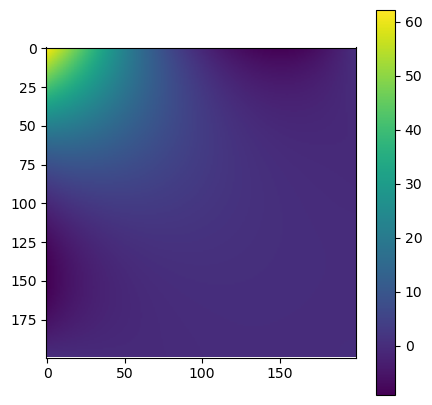

In [ ]:
data_ = torch.tensor(XU_grid, dtype=torch.float64)

u_pred = pibi.predict_u_inside(data_[:,0:2])
u_pibi = u_pred.reshape(X_grid.shape)

plt.figure(figsize=(5, 5))
plt.imshow(u_pibi.detach())
plt.colorbar()
plt.show()

In [ ]:
u_analitic = XU_grid[:,-1].reshape(X_grid.shape)

/tmp/ipykernel_892157/3689449685.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(u_pibi.detach()-u_analitic))


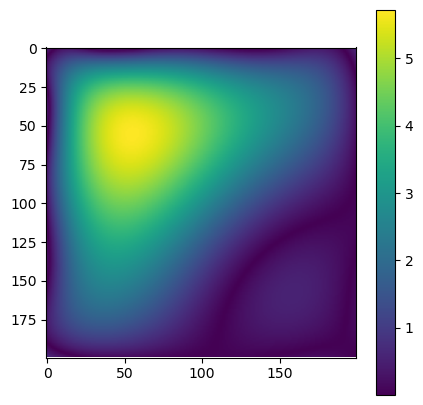

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(u_pibi.detach()-u_analitic))
plt.colorbar()
plt.show()